In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LogNorm

In [10]:
sars_vars_path = "/home/salipe/Desktop/rrm-genomic-extractor/notebooks/regions_val_covid_2.csv"
data = pd.read_csv(sars_vars_path)
for w in [0.002,0.004,0.006,0.008]:
    filt = data[(data["wndwPercent"] == w)]
    print(f'window:{w}')
    for metric in ["found","finalLength"]:
        print(f' {metric}: mean = {filt[metric].mean():.4f} std = ({filt[metric].std():.4f})')
    print('-------------------')

window:0.002
 found: mean = 7.5906 std = (1.0642)
 finalLength: mean = 4056.4409 std = (412.9604)
-------------------
window:0.004
 found: mean = 12.7165 std = (1.1945)
 finalLength: mean = 11781.6614 std = (622.0889)
-------------------
window:0.006
 found: mean = 13.9843 std = (1.1268)
 finalLength: mean = 16165.9528 std = (781.5033)
-------------------
window:0.008
 found: mean = 15.9606 std = (0.9293)
 finalLength: mean = 18938.2520 std = (828.2641)
-------------------


In [2]:
# Your confusion matrix data
covlabels = ["Alpha", "Beta", "Delta", "Epsilon", "Eta", "Gamma", "Iota", "Kappa", "Lambda", "Omicron"]
denvlabels = ["Type1", "Type2", "Type3", "Type4"]
data_str = """
[105885 0 314 0 0 0 5 0 0 0; 0 603 3 0 0 0 0 0 0 0; 0 0 14585 0 0 0 0 0 0 0; 0 0 41 586 0 0 0 0 0 0; 0 0 176 130 7734 0 0 0 0 0; 0 0 0 0 0 339 0 0 0 0; 4 0 542 0 0 0 8760 13 0 0; 0 0 0 0 0 0 0 38 0 0; 0 93 45 0 0 0 0 0 19047 0; 1496 0 20 0 0 0 0 0 1 173606]
"""

# Convert string data to numpy array
data_str = data_str.strip('[]\n ')
rows = data_str.split(';')
conf_matrix = np.array([list(map(int, row.split())) for row in rows])



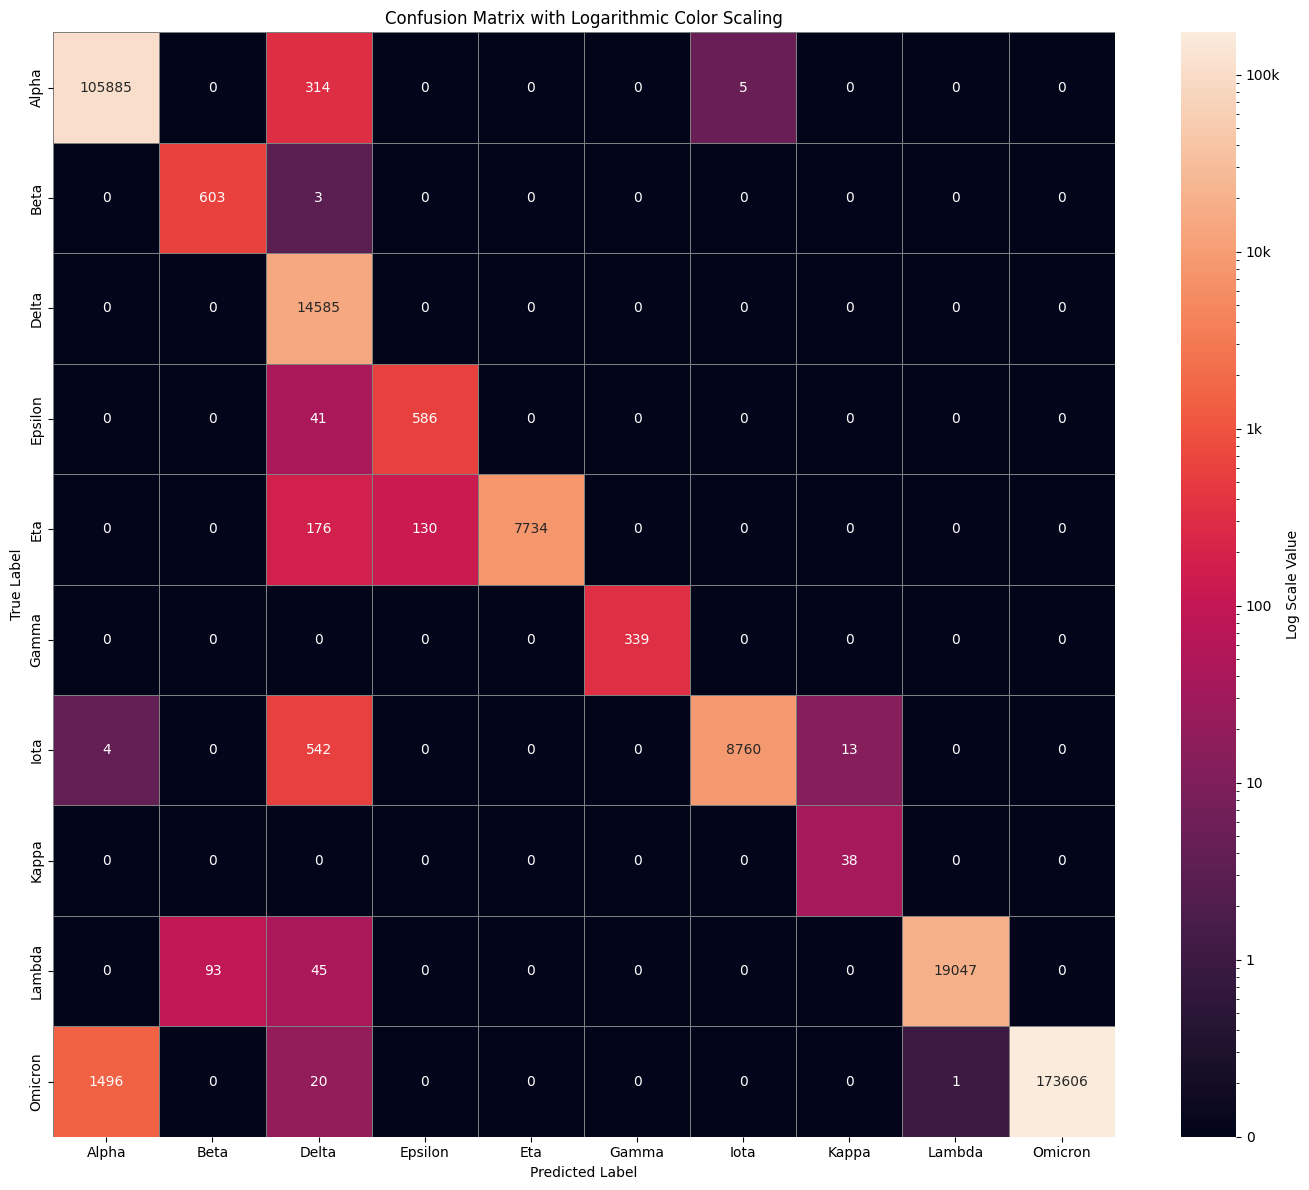

In [7]:
conf_matrix_viz = conf_matrix.astype(float)
conf_matrix_viz[conf_matrix_viz == 0] = 0.1

plt.figure(figsize=(14, 12))
ax = sns.heatmap(conf_matrix_viz, 
                 annot=conf_matrix,  # Show original values in annotations
                 fmt='d',
                 cmap='rocket',
                 norm=LogNorm(vmin=0.1, vmax=conf_matrix.max()),
                 linewidths=0.5,
                 linecolor='grey',
                 cbar_kws={'label': 'Log Scale Value'},
                 xticklabels=covlabels,
                 yticklabels=covlabels)

# Customize colorbar ticks
cbar = ax.collections[0].colorbar
tick_values = [0.1, 1, 10, 100, 1000, 10000, 100000]
cbar.set_ticks(tick_values)
cbar.set_ticklabels(['0', '1', '10', '100', '1k', '10k', '100k'])

ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.title('Confusion Matrix with Logarithmic Color Scaling')
plt.tight_layout()
plt.show()

In [ ]:
# Create plot
plt.figure(figsize=(12, 10))
ax = sns.heatmap(conf_matrix, 
                 annot=True, 
                 fmt='d', 
                 linewidths=0.5,
                 xticklabels=labels,
                 yticklabels=labels)

ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.title('Confusion Matrix')
plt.show()